In [1]:
#Import libraries for loading dataset from csv file
import pandas as pd
import sqlite3

#Import libraries for data analysis and visualisation.
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import datetime

#Changes pyplot style to Seaborn for better visualisations
plt.style.use('seaborn-v0_8')

#Loads data from csv file to Pandas dataframe
ufc_events = pd.read_csv('/kaggle/input/mma-dataset-2023-ufc/ufc_event_data.csv', parse_dates = ['event_date'])
ufc_fights = pd.read_csv('/kaggle/input/mma-dataset-2023-ufc/ufc_fight_data.csv')
ufc_fighters = pd.read_csv('/kaggle/input/mma-dataset-2023-ufc/ufc_fighter_data.csv', parse_dates = ['fighter_dob'])
ufc_fight_stats = pd.read_csv('/kaggle/input/mma-dataset-2023-ufc/ufc_fight_stat_data.csv')
pd.options.display.max_columns = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
events_date = ufc_events[['event_id','event_date']]
fighters_data = ufc_fighters[['fighter_id','fighter_height_cm','fighter_weight_lbs','fighter_reach_cm','fighter_stance']]
fighters_data = fighters_data.rename(columns = {'fighter_id':'f_1'})

fights_data = ufc_fights.copy()

In [3]:
#join to event_date
fights_data = pd.merge(fights_data, events_date, how='left', on='event_id')

#join to fighters_data
fights_data = pd.merge(fights_data, fighters_data, how='left', on='f_1')
fighters_data = fighters_data.rename(columns = {'f_1':'f_2'})
fights_data = pd.merge(fights_data, fighters_data, how='left', on='f_2')

fights_data = fights_data.rename(columns = {'fighter_height_cm_x':'height_1','fighter_weight_lbs_x':'weight_1','fighter_reach_cm_x':'reach_1','fighter_stance_x':'stance_1'})
fights_data = fights_data.rename(columns = {'fighter_height_cm_y':'height_2','fighter_weight_lbs_y':'weight_2','fighter_reach_cm_y':'reach_2','fighter_stance_y':'stance_2'})

In [4]:
fights_data = fights_data.rename(columns = {'fighter_height_cm_x':'height_1','fighter_weight_lbs_x':'weight_1','fighter_reach_cm_x':'reach_1','fighter_stance_x':'stance_1'})
fights_data = fights_data.rename(columns = {'fighter_height_cm_y':'height_2','fighter_weight_lbs_y':'weight_2','fighter_reach_cm_y':'reach_2','fighter_stance_y':'stance_2'})

In [5]:
#add date from ufc_events to ufc_fights
fights_data = fights_data.drop(['referee','fight_url','result_details','event_id'], axis=1)

In [6]:
#drop null f_1 and f_2
fights_data.dropna(subset=['f_1'], inplace=True)
fights_data.dropna(subset=['f_2'], inplace=True)

In [7]:
#verify if there is draws in our dataset
fights_data.loc[(fights_data['winner'] != fights_data['f_1']) & (fights_data['winner'] != fights_data['f_2'])]

,fight_id,f_1,f_2,winner,num_rounds,title_fight,weight_class,gender,result,finish_round,finish_time,event_date,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2


In [8]:
from dateutil import relativedelta
import pandas as pd

def fighter_age(f_id, date):
    f_infos = ufc_fighters.loc[ufc_fighters['fighter_id'] == f_id]
    event_date = pd.to_datetime(date, format='%Y-%m-%d')
    fighter_dob = pd.to_datetime(f_infos['fighter_dob'].values[0], format='%Y-%m-%d')
    age = relativedelta.relativedelta(event_date, fighter_dob)
    return age.years

test_age = fighter_age(fights_data.loc[1]['f_1'], fights_data.loc[1]['event_date'])
print(test_age)

28


In [9]:
#compute age for each fighter
fights_data['age_1'] = 0
fights_data['age_2'] = 0
for i, r in fights_data.iterrows():
    try:
        fights_data.loc[i, 'age_1'] = fighter_age(r['f_1'], r['event_date'])
        fights_data.loc[i, 'age_2'] = fighter_age(r['f_2'], r['event_date'])
    except AssertionError:
        exit(1)

In [10]:
fights_data.loc[0,'age_1']

30

In [11]:
def fighter_xp(id, date):
    f_infos = ufc_fighters.loc[ufc_fighters['fighter_id'] == id]
    f_fights = fights_data.loc[(fights_data['f_1'] == id) | (fights_data['f_2'] == id)]
    wins = 0
    loses = 0
    draws = 0
    for i, r in f_fights.iterrows():
        if pd.to_datetime(r['event_date'], format='%Y-%m-%d') < pd.to_datetime(date, format='%Y-%m-%d'):
            if r['winner'] == id:
                wins += 1 
            else:
                loses += 1
    total_fights = wins + loses
    wins_ratio = wins / total_fights if total_fights > 0 else 0
    loses_ratio = loses / total_fights if total_fights > 0 else 0
    fighter_xp = pd.DataFrame(data={'wins': [wins], 'loses': [loses], 'total': [total_fights]})
    return fighter_xp

In [12]:
#compute xp for each fighters
fights_data['total_fights_1'] = 0
fights_data['total_fights_2'] = 0

fights_data['wins_1'] = 0
fights_data['wins_2'] = 0

fights_data['loses_1'] = 0
fights_data['loses_2'] = 0

for i, r in fights_data.iterrows():
    try:
        fighter_xp_1 = fighter_xp(r['f_1'], r['event_date'])
        fighter_xp_2 = fighter_xp(r['f_2'], r['event_date'])
        
        fights_data.loc[i, 'total_fights_1'] = fighter_xp_1['total'].values[0]
        fights_data.loc[i, 'total_fights_2'] = fighter_xp_2['total'].values[0]
        
        fights_data.loc[i, 'wins_1'] = fighter_xp_1['wins'].values[0]
        fights_data.loc[i, 'wins_2'] = fighter_xp_2['wins'].values[0]
        
        fights_data.loc[i, 'loses_1'] = fighter_xp_1['loses'].values[0]
        fights_data.loc[i, 'loses_2'] = fighter_xp_2['loses'].values[0]
        
    except AssertionError:
        exit(1)

In [13]:
def winner_nbr(f,w):
    if f == w:
        return '1'
    else:
        return '2'

for i, r in fights_data.iterrows():
    try:
        fighter = fights_data.loc[i, 'f_1']
        winner = fights_data.loc[i, 'winner']
        fights_data.loc[i, 'winner'] = winner_nbr(fighter,winner)
    except AssertionError:
        exit(1)

In [14]:
fights_data = fights_data.drop(['finish_round','finish_time','event_date'], axis=1)

In [15]:
#drop unused column
#fights_data = fights_data.drop(['f_1','f_2'], axis=1)

fights_data.head()

,fight_id,f_1,f_2,winner,num_rounds,title_fight,weight_class,gender,result,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,total_fights_1,total_fights_2,wins_1,wins_2,loses_1,loses_2
0,7218,2976.0,2884.0,2,5,F,Lightweight,M,KO/TKO,172.72,155.0,180.34,Switch,177.80,155.0,177.80,Southpaw,30,32,8,7,6,5,2,2
1,7217,1662.0,2464.0,1,3,F,Featherweight,M,Decision,177.80,145.0,177.80,Southpaw,170.18,145.0,180.34,Orthodox,28,32,7,14,6,9,1,5
2,7216,981.0,179.0,1,3,F,Women's Strawweight,F,KO/TKO,167.64,115.0,165.10,Orthodox,160.02,115.0,157.48,Orthodox,36,37,9,13,6,6,3,7
3,7215,3831.0,2974.0,1,3,F,Welterweight,M,Submission,185.42,170.0,195.58,Orthodox,177.80,170.0,170.18,Switch,29,26,5,3,4,1,1,2
4,7214,1108.0,2320.0,2,3,F,Featherweight,M,Submission,175.26,145.0,182.88,Orthodox,175.26,145.0,175.26,Switch,28,27,10,10,7,5,3,5


In [16]:
fights_data.weight_class.unique()

array(['Lightweight', 'Featherweight', "Women's Strawweight",
       'Welterweight', 'Bantamweight', 'Middleweight', 'Heavyweight',
       "Women's Bantamweight", "Women's Flyweight", 'Flyweight',
       'Light Heavyweight', 'Catch Weight', "Women's Featherweight",
       'Open Weight', nan], dtype=object)

In [17]:
fights_data.weight_class.value_counts()

Lightweight              1240
Welterweight             1227
Middleweight              960
Featherweight             681
Heavyweight               669
Light Heavyweight         648
Bantamweight              594
Flyweight                 297
Women's Strawweight       272
Women's Flyweight         205
Women's Bantamweight      188
Open Weight               101
Catch Weight               62
Women's Featherweight      29
Name: weight_class, dtype: int64

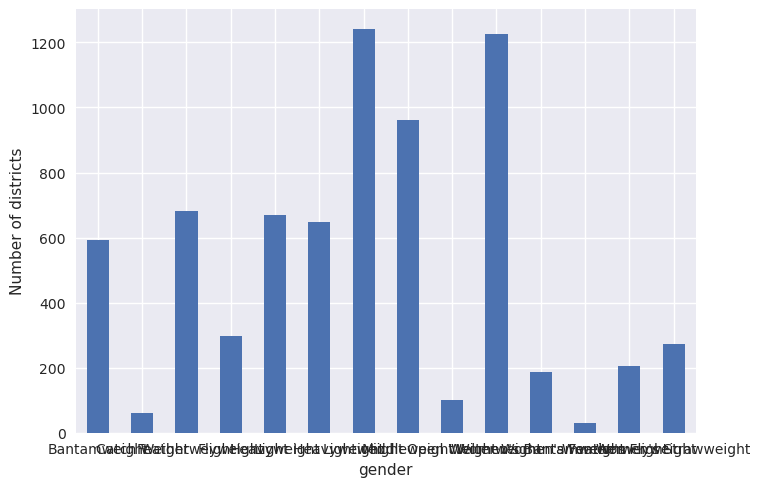

In [18]:
fights_data["weight_class"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("gender")
plt.ylabel("Number of districts")
plt.show()

In [19]:
for i, r in fights_data.loc[fights_data["weight_class"].isna()].iterrows():
    fights_data.loc[i,"weight_class"] = 'Light Heavyweight'

fights_data.loc[fights_data["weight_class"].isna()]

,fight_id,f_1,f_2,winner,num_rounds,title_fight,weight_class,gender,result,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,total_fights_1,total_fights_2,wins_1,wins_2,loses_1,loses_2


In [20]:
fights_data.stance_1.unique()

array(['Switch', 'Southpaw', 'Orthodox', nan, 'Open Stance', 'Sideways'],
      dtype=object)

In [21]:
for i, r in fights_data.loc[fights_data["stance_1"].isna()].iterrows():
    fights_data.loc[i,"stance_1"] = 'Orthodox'
    
for i, r in fights_data.loc[fights_data["stance_2"].isna()].iterrows():
    fights_data.loc[i,"stance_2"] = 'Orthodox'

In [22]:
null_rows_idx = fights_data.isnull().any(axis=1)
fights_data.loc[null_rows_idx]

,fight_id,f_1,f_2,winner,num_rounds,title_fight,weight_class,gender,result,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,total_fights_1,total_fights_2,wins_1,wins_2,loses_1,loses_2
2249,4969,1896.0,1197.0,1,3,F,Lightweight,M,Decision,172.72,155.0,172.72,Orthodox,177.80,155.0,NaN,Southpaw,33,22,15,1,9,1,6,0
2415,4803,2725.0,3832.0,1,3,F,Heavyweight,M,Submission,200.66,258.0,203.20,Orthodox,190.50,260.0,NaN,Orthodox,32,34,0,0,0,0,0,0
2442,4776,1174.0,1197.0,2,3,F,Lightweight,M,Decision,182.88,155.0,185.42,Orthodox,177.80,155.0,NaN,Southpaw,30,22,3,0,1,0,2,0
2539,4679,103.0,3029.0,1,3,F,Women's Flyweight,F,Submission,167.64,125.0,165.10,Orthodox,170.18,125.0,NaN,Switch,32,32,6,2,3,0,3,2
2606,4612,3342.0,2273.0,2,3,T,Featherweight,M,Decision,170.18,155.0,NaN,Orthodox,167.64,135.0,162.56,Orthodox,31,26,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7213,5,141.0,1962.0,1,N,F,Open Weight,M,KO/TKO,177.80,170.0,NaN,Southpaw,187.96,245.0,NaN,Orthodox,0,0,0,0,0,0,0,0
7214,4,2663.0,1952.0,1,N,F,Open Weight,M,Submission,NaN,NaN,NaN,Orthodox,190.50,210.0,NaN,Orthodox,0,0,0,0,0,0,0,0
7215,3,1060.0,2038.0,1,N,F,Open Weight,M,KO/TKO,182.88,210.0,NaN,Orthodox,195.58,275.0,NaN,Orthodox,0,0,0,0,0,0,0,0
7216,2,640.0,108.0,1,N,F,Open Weight,M,Submission,187.96,225.0,NaN,Orthodox,NaN,NaN,NaN,Orthodox,30,0,0,0,0,0,0,0


In [23]:
mean_values = pd.DataFrame()
mean_values['weights'] = fights_data.groupby('weight_class').weight_1.mean()
mean_values['heights'] = fights_data.groupby('weight_class').height_1.mean()
mean_values['reaches'] = fights_data.groupby('weight_class').reach_1.mean()
mean_values['ages'] = (fights_data.groupby('weight_class').age_1.mean() + fights_data.groupby('weight_class').age_1.mean())//2

mean_values.ages['Bantamweight']

29.0

In [24]:
for i, r in fights_data.loc[null_rows_idx].iterrows():
    if pd.isnull(fights_data.loc[i, "reach_1"]):
        fights_data.loc[i, "reach_1"] = mean_values.reaches[fights_data.loc[i, "weight_class"]]
    if pd.isnull(fights_data.loc[i, "reach_2"]):
        fights_data.loc[i, "reach_2"] = mean_values.reaches[fights_data.loc[i, "weight_class"]]

    if pd.isnull(fights_data.loc[i, "weight_1"]):
        fights_data.loc[i, "weight_1"] = mean_values.weights[fights_data.loc[i, "weight_class"]]
    if pd.isnull(fights_data.loc[i, "weight_2"]):
        fights_data.loc[i, "weight_2"] = mean_values.weights[fights_data.loc[i, "weight_class"]]

    if pd.isnull(fights_data.loc[i, "height_1"]):
        fights_data.loc[i, "height_1"] = mean_values.heights[fights_data.loc[i, "weight_class"]]
    if pd.isnull(fights_data.loc[i, "height_2"]):
        fights_data.loc[i, "height_2"] = mean_values.heights[fights_data.loc[i, "weight_class"]]
        
    if r["age_1"] == 0.:
        fights_data.loc[i, 'age_1'] = mean_values.ages[fights_data.loc[i, "weight_class"]]
    if r["age_2"] == 0.:
        fights_data.loc[i, 'age_2'] = mean_values.ages[fights_data.loc[i, "weight_class"]]
        


In [25]:
null_rows_idx = fights_data.isnull().any(axis=1)
fights_data.loc[null_rows_idx]

,fight_id,f_1,f_2,winner,num_rounds,title_fight,weight_class,gender,result,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,total_fights_1,total_fights_2,wins_1,wins_2,loses_1,loses_2


In [26]:
fights_data.age_1.unique()

array([30, 28, 36, 29, 39, 34, 25, 18, 24, 26, 32, 27, 31, 35, 33, 40, 38,
       37, 41, 23, 22, 21, 44, 42, 43, 20, 19, 45, 47, 46,  0, 15])

In [27]:
for i, r in fights_data.loc[fights_data["num_rounds"] == 'N'].iterrows():
    fights_data.loc[i,"num_rounds"] = '5'
    
for i, r in fights_data.loc[(fights_data["num_rounds"] == '2') | (fights_data["num_rounds"] == '1')].iterrows():
    fights_data.loc[i,"num_rounds"] = '3'

In [28]:
fights_data.gender.unique()

array(['M', 'F'], dtype=object)

In [29]:
#duplicate dataset and invert f_1 and f_2
duplicate = fights_data.copy()
duplicate = duplicate.rename(columns = {'f_1':'f_2','f_2':'f_1','height_1':'height_2','height_2':'height_1',
                                        'weight_1':'weight_2','weight_2':'weight_1','reach_1':'reach_2','reach_2':'reach_1',
                                        'stance_1':'stance_2','stance_2':'stance_1','age_1':'age_2','age_2':'age_1'})

for index, row in duplicate.iterrows():
    if row['winner'] == '1':
        duplicate.at[index, 'winner'] = '2'
    elif row['winner'] == '2':
        duplicate.at[index, 'winner'] = '1'
        
duplicate.head()

,fight_id,f_2,f_1,winner,num_rounds,title_fight,weight_class,gender,result,height_2,weight_2,reach_2,stance_2,height_1,weight_1,reach_1,stance_1,age_2,age_1,total_fights_1,total_fights_2,wins_1,wins_2,loses_1,loses_2
0,7218,2976.0,2884.0,1,5,F,Lightweight,M,KO/TKO,172.72,155.0,180.34,Switch,177.80,155.0,177.80,Southpaw,30,32,8,7,6,5,2,2
1,7217,1662.0,2464.0,2,3,F,Featherweight,M,Decision,177.80,145.0,177.80,Southpaw,170.18,145.0,180.34,Orthodox,28,32,7,14,6,9,1,5
2,7216,981.0,179.0,2,3,F,Women's Strawweight,F,KO/TKO,167.64,115.0,165.10,Orthodox,160.02,115.0,157.48,Orthodox,36,37,9,13,6,6,3,7
3,7215,3831.0,2974.0,2,3,F,Welterweight,M,Submission,185.42,170.0,195.58,Orthodox,177.80,170.0,170.18,Switch,29,26,5,3,4,1,1,2
4,7214,1108.0,2320.0,1,3,F,Featherweight,M,Submission,175.26,145.0,182.88,Orthodox,175.26,145.0,175.26,Switch,28,27,10,10,7,5,3,5


In [30]:
dataset = pd.concat([fights_data,duplicate])
dataset = dataset.drop(['fight_id','result','gender','f_1','f_2','total_fights_1','total_fights_2'], axis = 1)
dataset.head()

,winner,num_rounds,title_fight,weight_class,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,wins_1,wins_2,loses_1,loses_2
0,2,5,F,Lightweight,172.72,155.0,180.34,Switch,177.80,155.0,177.80,Southpaw,30,32,6,5,2,2
1,1,3,F,Featherweight,177.80,145.0,177.80,Southpaw,170.18,145.0,180.34,Orthodox,28,32,6,9,1,5
2,1,3,F,Women's Strawweight,167.64,115.0,165.10,Orthodox,160.02,115.0,157.48,Orthodox,36,37,6,6,3,7
3,1,3,F,Welterweight,185.42,170.0,195.58,Orthodox,177.80,170.0,170.18,Switch,29,26,4,1,1,2
4,2,3,F,Featherweight,175.26,145.0,182.88,Orthodox,175.26,145.0,175.26,Switch,28,27,7,5,3,5


In [31]:
dataset.winner.value_counts()/len(dataset)

2    0.5
1    0.5
Name: winner, dtype: float64

In [32]:
#spliting data
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

splitter = StratifiedShuffleSplit(n_splits=5, test_size=0.15, random_state=42)
strat_splits = []
for train_index, test_index in splitter.split(dataset, dataset["winner"]):
    strat_train_set_n = dataset.iloc[train_index]
    strat_test_set_n = dataset.iloc[test_index]
    strat_splits.append([strat_train_set_n, strat_test_set_n])

strat_train_set, strat_test_set = strat_splits[0]
strat_train_set, strat_test_set = train_test_split(dataset, test_size=0.15, stratify=dataset["winner"], random_state=42)

In [33]:
fights = strat_train_set.drop("winner", axis=1)
fights_labels = strat_train_set["winner"].copy()
len(fights_labels)

12216

Creating Pipelines

In [34]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn import set_config

from sklearn.pipeline import make_pipeline

num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [35]:
fights.head()

,num_rounds,title_fight,weight_class,height_1,weight_1,reach_1,stance_1,height_2,weight_2,reach_2,stance_2,age_1,age_2,wins_1,wins_2,loses_1,loses_2
7111,3,F,Open Weight,180.34,230.0,187.234286,Orthodox,182.88,265.0,187.234286,Switch,15,15,4,1,3,1
409,3,F,Lightweight,177.80,155.0,180.340000,Orthodox,172.72,155.0,177.800000,Southpaw,36,34,11,10,7,8
6405,3,F,Lightweight,167.64,135.0,172.720000,Orthodox,170.18,155.0,172.720000,Southpaw,26,31,2,5,0,2
583,3,F,Flyweight,170.18,125.0,185.420000,Southpaw,170.18,125.0,172.720000,Orthodox,30,38,3,2,2,3
2776,3,F,Middleweight,190.50,185.0,203.200000,Orthodox,193.04,185.0,203.200000,Switch,25,28,0,0,1,0


In [36]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = ["height_1", "height_2", "weight_1", "weight_2",
               "reach_1", "reach_2", "age_1", "age_2", "wins_1","wins_2","loses_1","loses_2"]
cat_attribs = ["num_rounds", "title_fight", "weight_class", "stance_1","stance_2",
               "reach_1", "reach_2", "age_1", "age_2", "wins_1","wins_2","loses_1","loses_2"]

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown="ignore"))

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs),
])

In [37]:
fights_prepared = preprocessing.fit_transform(fights)

In [38]:
strat_train_set.winner.value_counts()/len(strat_train_set)

2    0.5
1    0.5
Name: winner, dtype: float64

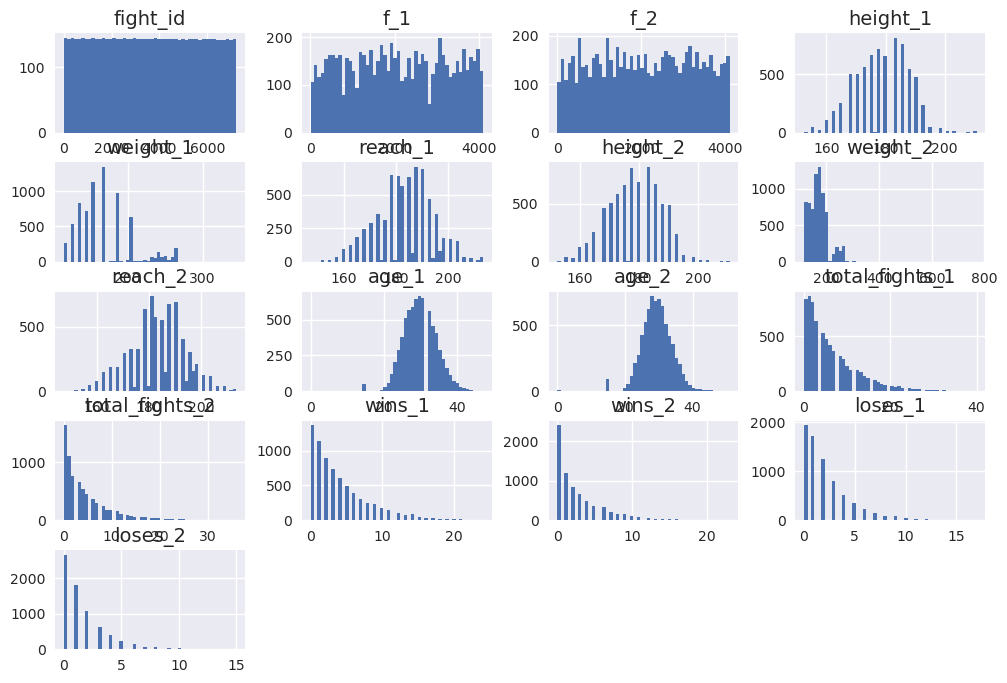

In [39]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

fights_data.hist(bins=50, figsize=(12, 8))
plt.show()

In [40]:
#transform text values


In [41]:
#scaling

In [42]:
def fighter_name(id):
    return ufc_fighters.loc[ufc_fighters.fighter_id == id].fighter_f_name + ' ' + ufc_fighters.loc[ufc_fighters.fighter_id == id].fighter_l_name